<h1 style='color: green; font-size: 36px; font-weight: bold;'>Exploratory Data Analysis: Brasilian houses to rent</h1>

## Importando Bibliotecas

In [1]:
# Import das bibliotecas e setting de configurações 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 400)

%matplotlib inline
plt.rc('figure', figsize = (14, 6))

## Leitura dos dados

Importando o dataset "houses_to_rent_analisado", onde já foi realizado tratamento dos dados:

In [2]:
dataset = pd.read_csv('datasets/houses_to_rent_analisado.csv', sep=',')

In [3]:
dataset.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent amount,property tax,fire insurance,total
0,São Paulo,70,2,1,1,7,0,0,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,0,1,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,0,1,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,0,1,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,1,1,0,800,25,11,836


## Overview

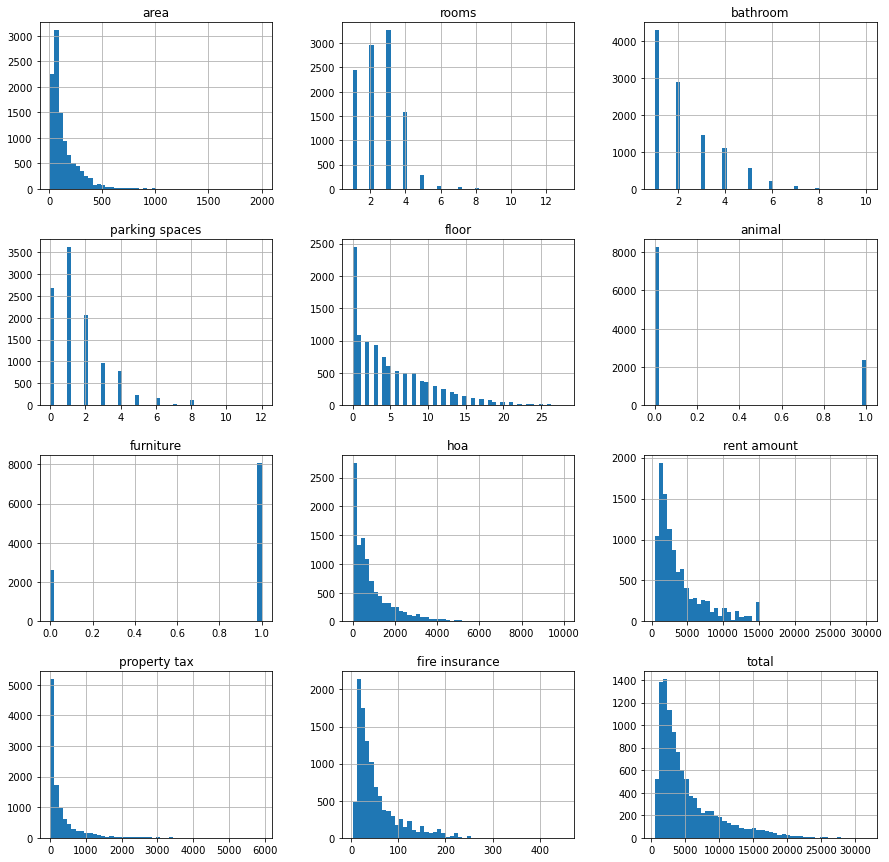

In [4]:
histograma = dataset.hist(bins=50, figsize=(15, 15))

Nos gráficos, nitidamente, temos uma assimetria à direita em todas as variáveis, menos em "animal" e "furniture", ou seja, praticamente todos os dados estão jogados para o lado esquerdo. O nome de assimetria à direita é dado devido a linha que se estende da queda da curva fica à direita, criando uma assimetria no lado com menos valores. Os dados de "animal" e "furniture" são binários (0 ou 1), onde 0 indica negação e 1 afirmação.

## Exploratory Data Analysis

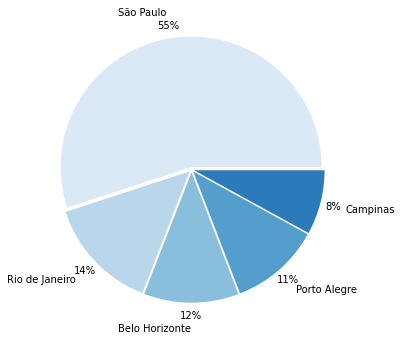

In [5]:
labels = ['São Paulo', 'Rio de Janeiro', 'Belo Horizonte', 'Porto Alegre', 'Campinas']
fig, ax = plt.subplots(figsize=(10, 6))
colors = sns.color_palette('Blues')
ax.pie(dataset['city'].value_counts(), labels=labels, autopct='%1.0f%%', pctdistance=1.1, explode = [0.02, 0.02, 0.02, 0.02, 0.02], labeldistance=1.2, colors=colors) 
plt.show()

É possível perceber um grade desbalanceamento na base de dados, onde a cidade de São Paulo possui mais da metade dos registros de imóveis.

In [6]:
dataset.describe().round(2).drop(['parking spaces', 'animal', 'furniture'], axis=1)

,area,rooms,bathroom,floor,hoa,rent amount,property tax,fire insurance,total
count,10660.00,10660.00,10660.00,10660.00,10660.00,10660.00,10660.00,10660.00,10660.00
mean,140.95,2.50,2.23,5.01,911.06,3881.49,325.16,53.10,5171.00
std,133.45,1.17,1.40,5.28,1104.39,3374.12,539.92,47.24,4419.44
min,11.00,1.00,1.00,0.00,0.00,450.00,0.00,3.00,499.00
25%,56.00,2.00,1.00,1.00,170.00,1522.50,38.00,21.00,2057.00
50%,90.00,2.00,2.00,3.00,556.50,2650.00,125.00,36.00,3566.50
75%,181.00,3.00,3.00,8.00,1227.50,5000.00,375.00,68.00,6719.75
max,2000.00,13.00,10.00,28.00,10000.00,30000.00,5917.00,451.00,31580.00


### Influência do animal (aceitar ou não) nos valores dos alugueis

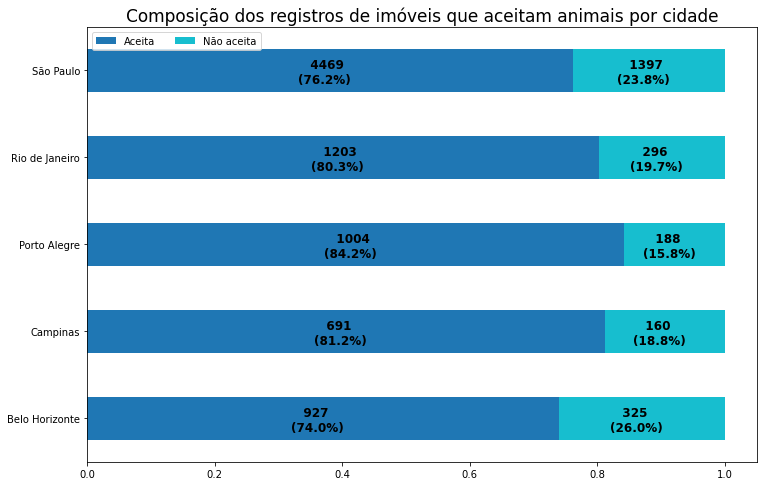

In [7]:
cross_tab = pd.crosstab(index=dataset['city'], columns=dataset['animal'].replace({0: 'Aceita', 1: 'Não aceita'}))
cross_tab_prop = pd.crosstab(index=dataset['city'], columns=dataset['animal'].replace({0: 'Aceita', 1: 'Não aceita'}), normalize="index")
ax = cross_tab_prop.plot(kind='barh', stacked=True, colormap='tab10', figsize=(12,8))
ax.set_title('Composição dos registros de imóveis que aceitam animais por cidade', fontdict={'fontsize': 17})
ax.legend(loc="upper left", ncol=2)
ax.set(ylabel=None)

for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=(y_loc - proportion) + (proportion / 2) - 0.05,
                 y=n - 0.15,
                 s=f'   {count}\n({np.round(proportion * 100, 1)}%)', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")

plt.show()

Há uma grande desproporção na quantidade de imovéis que aceitam ou não animais, onde em todas as cidades a quantidade de aceita é mais do que dobro das que não aceitam.

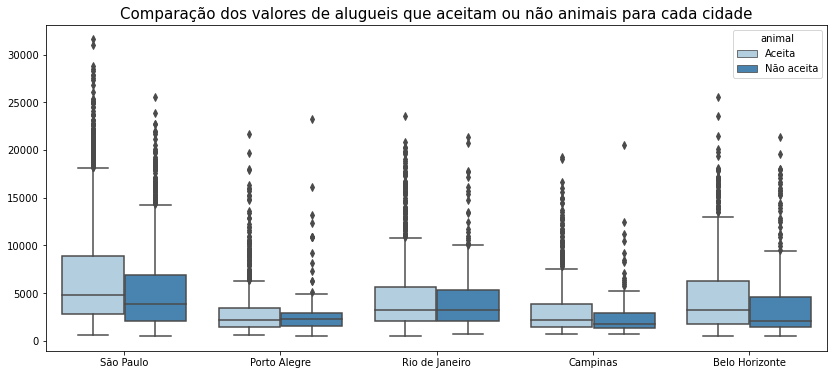

In [8]:
ax = sns.boxplot(data=dataset.replace({0: 'Aceita', 1: 'Não aceita'}), x='city', y='total', hue='animal', palette='Blues')
ax.set_title('Comparação dos valores de alugueis que aceitam ou não animais para cada cidade', fontdict={'fontsize': 15})
ax.set(ylabel=None, xlabel=None)
plt.show()

### Impacto dos imóveis serem mobiliados sobre o valor do aluguel

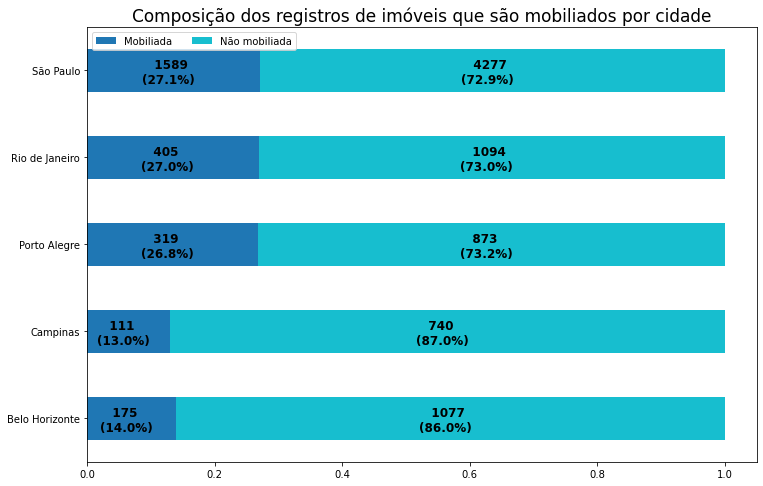

In [9]:
cross_tab = pd.crosstab(index=dataset['city'], columns=dataset['furniture'].replace({0:'Mobiliada', 1: 'Não mobiliada'}))
cross_tab_prop = pd.crosstab(index=dataset['city'], columns=dataset['furniture'].replace({0:'Mobiliada', 1: 'Não mobiliada'}), normalize="index")
ax = cross_tab_prop.plot(kind='barh', stacked=True, colormap='tab10', figsize=(12,8))
ax.set_title('Composição dos registros de imóveis que são mobiliados por cidade', fontdict={'fontsize': 17})
ax.legend(loc="upper left", ncol=2)
ax.set(ylabel=None)

for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=(y_loc - proportion) + (proportion / 2) - 0.05,
                 y=n - 0.15,
                 s=f'   {count}\n({np.round(proportion * 100, 1)}%)', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")

plt.show()

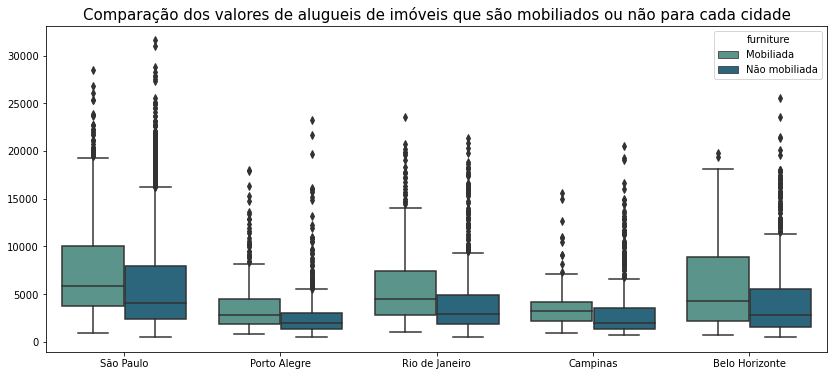

In [10]:
ax = sns.boxplot(data=dataset.replace({0:'Mobiliada', 1: 'Não mobiliada'}), x='city', y='total', hue='furniture', palette='crest')
ax.set_title('Comparação dos valores de alugueis de imóveis que são mobiliados ou não para cada cidade', fontdict={'fontsize': 15})
ax.set(ylabel=None, xlabel=None)
plt.show()

### Influência do andar sobre os alugueis dos apartamentos (a partir do 1 andar)


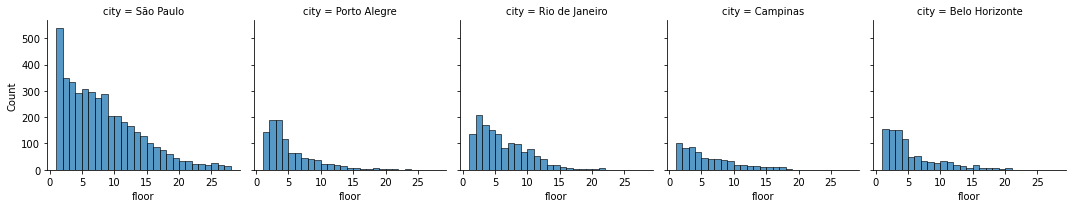

In [11]:
ax = sns.FacetGrid(dataset[dataset['floor'] > 0], col="city", palette='crest')
ax.map_dataframe(sns.histplot, x="floor", binwidth=1, binrange=(1, 28))
plt.show()

Para análise da influência do andar sobre valor total de aluguel será utilizada apenas a cidade de São Paulo, pois ocorre uma grande desproporção dos dados entre as cidades e a cidade de São Paulo possui registro de imóveis em um range maior de andares.

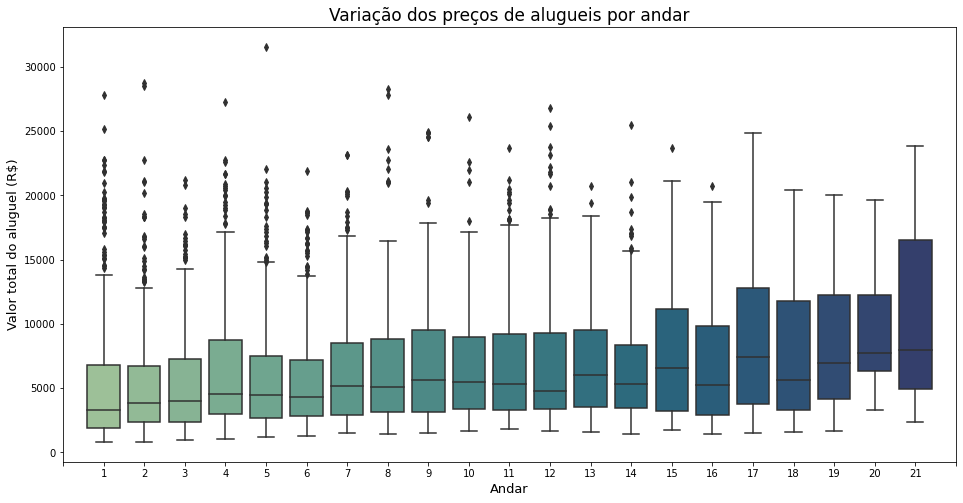

In [12]:
plt.figure(figsize=(16, 8))
andares_sao_paulo = dataset[(dataset['city'] == 'São Paulo') & (dataset['floor'] < 22) & (dataset['floor'] > 0)][['floor', 'total']]
ax = sns.boxplot(x="floor", y="total", data=andares_sao_paulo, palette='crest')
ax.set_title('Variação dos preços de alugueis por andar', fontdict={'fontsize': 17})
ax.set_xlabel('Andar', fontdict={'fontsize': 13})
ax.set_ylabel('Valor total do aluguel (R$)', fontdict={'fontsize': 13})
plt.xlim((0,21))
plt.xticks(np.arange(-1, 22, 1))
plt.show()

O gráfico demostra uma tendência de aumento nos valores dos alugueis com o aumento da posição (andar) dos imóveis. As possíveis explicações de acordo com os especialistas são: à vista e quantidade de ruídos. Um apartamento no andar mais alto proporciona uma melhor vista. Uma menor quantidade de ruídos vindos da rua faz com que os andares superiores sejam os preferidos dos moradores.

### Influência da área sobre os alugueis dos apartamentos 

A área é uma das features de maior correlação para o valor total do aluguel. Já é de conhecimento de todos que esta correlação é positiva, ou seja, quanto maior o valor da área maior será o valor do aluguel, como demostrado no gráfico de dispersão a seguir.

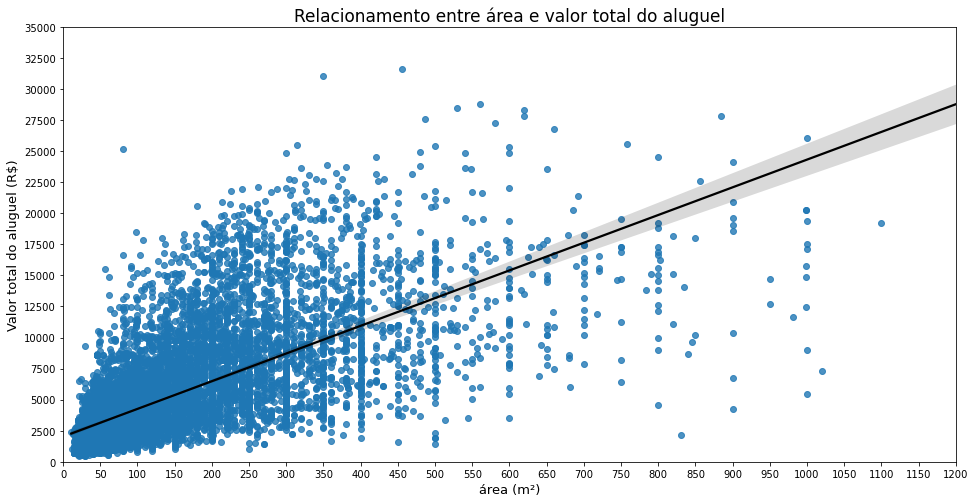

In [16]:
plt.figure(figsize=(16, 8))
area = dataset[['area', 'total']]
ax = sns.regplot(x="area", y="total", data=area, line_kws={"color": "black"})
ax.set_title('Relacionamento entre área e valor total do aluguel', fontdict={'fontsize': 17})
ax.set_xlabel('área (m²)', fontdict={'fontsize': 13})
ax.set_ylabel('Valor total do aluguel (R$)', fontdict={'fontsize': 13})
plt.xlim((0,1200))
plt.ylim((0,35000))
plt.xticks(np.arange(0, 1250, 50))
plt.yticks(np.arange(0, 37500, 2500))
plt.show()

O gráfico anterior traz a tona um detalhe muito importante que não é descrido no conjunto de dados, a localização geográfica do imóvel. Imóveis localizados em bairros mais localizados na periferia das cidades vão possuir um valor de imóvel por metro área quadrada mais barato do que os imóveis que são localizados no centro.

### Influência do andar sobre a área dos apartamentos 

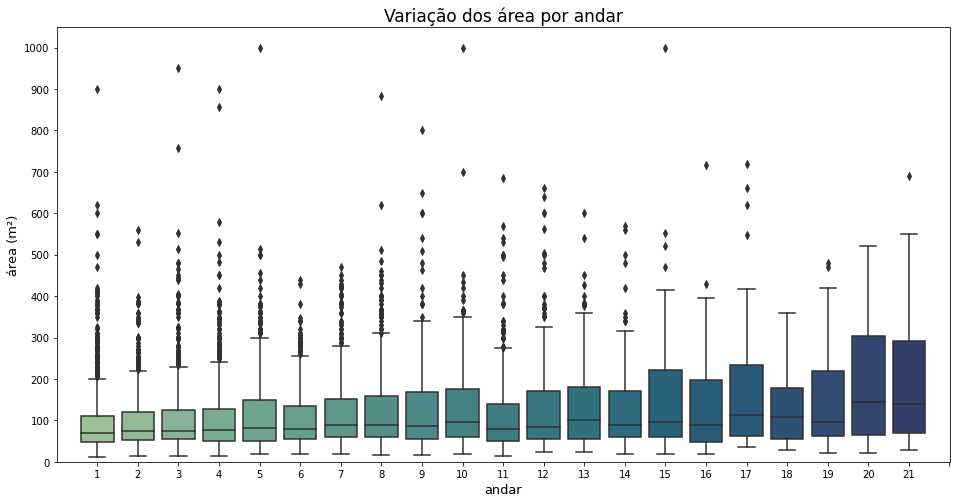

In [39]:
andares_df = dataset[(dataset['floor'] < 22) & (dataset['floor'] > 0)][['floor', 'area']]
plt.figure(figsize=(16, 8))
ax = sns.boxplot(x="floor", y="area", data=andares_df, palette='crest')   # , hue='total_em_intervalos'
ax.set_title('Variação dos área por andar', fontdict={'fontsize': 17})
ax.set_xlabel('andar', fontdict={'fontsize': 13})
ax.set_ylabel('área (m²)', fontdict={'fontsize': 13})
plt.xlim((-1,21))
plt.ylim((0,1050))
plt.xticks(np.arange(0, 22, 1))
plt.yticks(np.arange(0, 1100, 100))
plt.show()

### Valores médios de área por intervalo de alugueis

Utilizando a função cut do pandas para segmentar e classificar valores totais:

In [39]:
intervalos_total = pd.cut(dataset.total, [0, 1500, 3000, 4500, 6000, 7500, 10000, np.inf])
intervalos_total[:3]

0     (4500.0, 6000.0]
1    (7500.0, 10000.0]
2     (3000.0, 4500.0]
Name: total, dtype: category
Categories (7, interval[float64, right]): [(0.0, 1500.0] < (1500.0, 3000.0] < (3000.0, 4500.0] < (4500.0, 6000.0] < (6000.0, 7500.0] < (7500.0, 10000.0] < (10000.0, inf]]

Criando um novo dataframe com as infomações dos intervalos:

In [40]:
df_intervalos = pd.DataFrame({'intervalo_total': intervalos_total,
                                'area': dataset['area'],
                                'quartos': dataset['rooms'],
                                'condominio': dataset['hoa'],
                                'IPTU': dataset['property tax'],
                                'aluguel': dataset['rent amount'],
                                'seguro_incendio': dataset['fire insurance'],
                                'cidades': dataset['city']
                                })

In [41]:
medias_areas_por_cidade = df_intervalos.pivot_table(values='area',       # coluna agregada
                                                    index='intervalo_total',    # Intervalo que serão agregados os valores
                                                    columns='cidades',   # colunas
                                                    aggfunc='mean').round(2)    # função que irá ser execultada para agrupar os valores
medias_areas_por_cidade

cidades,Belo Horizonte,Campinas,Porto Alegre,Rio de Janeiro,São Paulo
intervalo_total,,,,,
"(0.0, 1500.0]",58.15,55.79,49.65,41.08,47.32
"(1500.0, 3000.0]",95.83,83.53,74.34,62.82,66.34
"(3000.0, 4500.0]",158.83,142.98,133.70,94.23,100.62
"(4500.0, 6000.0]",231.87,195.49,189.79,117.29,137.74
"(6000.0, 7500.0]",283.08,257.71,243.70,140.47,174.41
"(7500.0, 10000.0]",340.05,342.82,316.52,185.24,224.81
"(10000.0, inf]",370.02,422.05,353.32,273.11,313.44


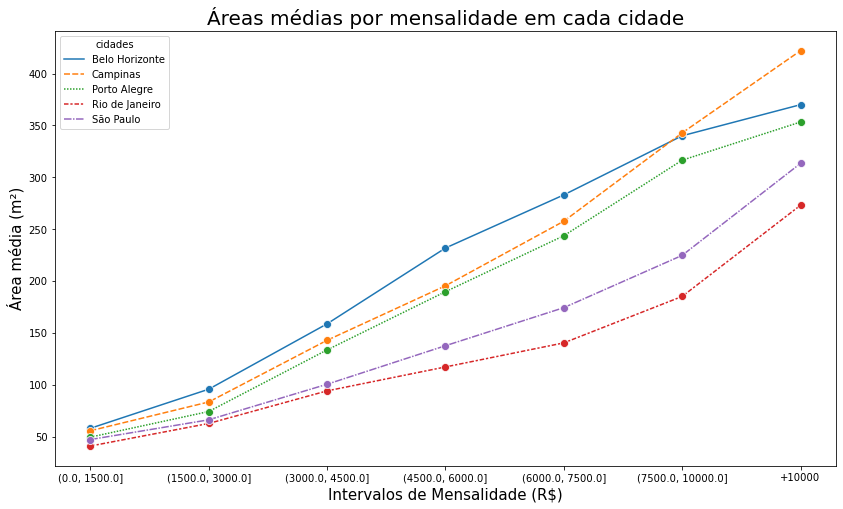

In [42]:
medias_areas_por_cidade = medias_areas_por_cidade.reset_index() # forma de corrigir o erro ao utilizar o df no lineplot
plt.figure(figsize=(14, 8))
x1 = sns.lineplot(data=medias_areas_por_cidade, marker='o', markersize=8)
x1.set_ylabel('Área média (m²)', fontdict={'fontsize': 15})
x1.set_xlabel('Intervalos de Mensalidade (R$)', fontdict={'fontsize': 15})
x1.set_xticklabels([0] + list(medias_areas_por_cidade['intervalo_total'][:-1]) + ['+10000'])
x1.set_title('Áreas médias por mensalidade em cada cidade', fontdict={'fontsize': 20})
plt.show()

O aumento da área implica no aumento do custo total de aluguel, o que confirma correlação positiva entre as features. O Rio de Janeiro é a cidade que possui a menor média de área para todas as classes de mensalidade, enquanto Belo Horizonte possui a maior média de área para as classes até R$10000,00. Então, provando que a há influência cidade (localização) sobre o custo total de aluguel dos imóveis.

In [43]:
medias_IPTU_por_cidade = df_intervalos.pivot_table(values='IPTU',       # coluna agregada
                                                    index='intervalo_total',    # Intervalo que serão agregados os valores
                                                    columns='cidades',   # colunas
                                                    aggfunc='mean').round(2)   # função que irá ser execultada para agrupar os valores
medias_IPTU_por_cidade

cidades,Belo Horizonte,Campinas,Porto Alegre,Rio de Janeiro,São Paulo
intervalo_total,,,,,
"(0.0, 1500.0]",42.65,32.81,32.50,28.12,30.16
"(1500.0, 3000.0]",109.88,82.96,73.44,71.56,62.94
"(3000.0, 4500.0]",225.97,182.22,142.12,173.50,150.81
"(4500.0, 6000.0]",308.33,294.72,336.62,268.34,294.01
"(6000.0, 7500.0]",423.97,363.29,369.00,334.42,439.56
"(7500.0, 10000.0]",538.70,425.09,494.85,567.34,681.14
"(10000.0, inf]",821.47,705.03,603.37,873.87,1236.78


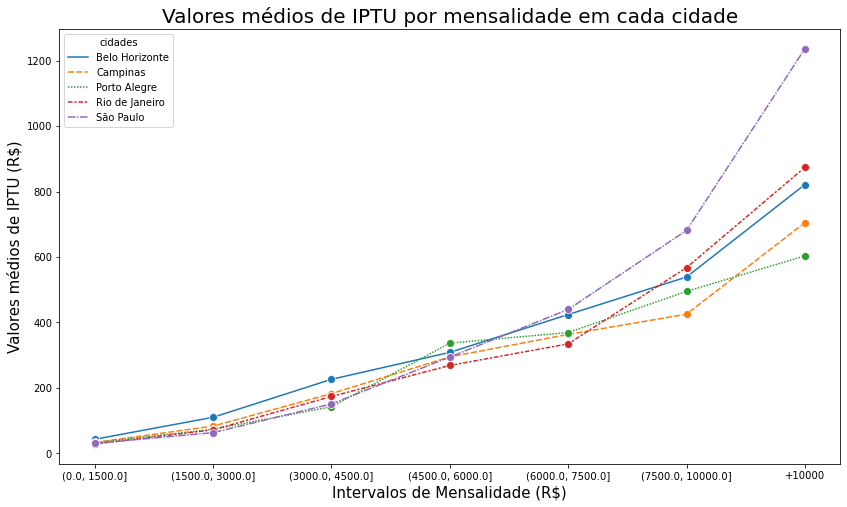

In [44]:
medias_IPTU_por_cidade = medias_IPTU_por_cidade.reset_index() # forma de corrigir o erro ao utilizar o df no lineplot
plt.figure(figsize=(14, 8))
x1 = sns.lineplot(data=medias_IPTU_por_cidade, marker='o', markersize=8)
x1.set_ylabel('Valores médios de IPTU (R$)', fontdict={'fontsize': 15})
x1.set_xlabel('Intervalos de Mensalidade (R$)', fontdict={'fontsize': 15})
x1.set_xticklabels([0] + list(medias_IPTU_por_cidade['intervalo_total'][:-1]) + ['+10000'])
x1.set_title('Valores médios de IPTU por mensalidade em cada cidade', fontdict={'fontsize': 20})
plt.show()

Os valores médios de IPTU se mantem relativamente parecidos no intervalo de 0 até 7500,00 reais. Para valores médios de alugueis maiores de R$7500,00, na cidade de São Paulo há um grande aumento nos valores de IPTU, se distanciando bastante das outras cidades.

### Composição do preço dos alugueis para a cidade de São Paulo por intervalo de área

Escolhendo a cidade de São Paulo para analise, já que a cidade com maior número de informações. Separando novamente as informações em um dataset por intervalos de alugueis e agrupando as informações através das médias dos dados de cada intervalo.

In [45]:
intervalos_area = pd.cut(dataset.area, [0, 50, 75, 100, 125, 150, 200, np.inf])

df_intervalos_area = pd.DataFrame({'intervalo_area': intervalos_area,
                                'condominio': dataset['hoa'],
                                'IPTU': dataset['property tax'],
                                'aluguel': dataset['rent amount'],
                                'seguro_incendio': dataset['fire insurance'],
                                'cidades': dataset['city']
                                })

df_cidade_SP = df_intervalos.query('cidades == "São Paulo"')


composicao_area_SP = df_intervalos_area.pivot_table(values=['condominio', 'IPTU', 'aluguel', 'seguro_incendio'],
                                    index='intervalo_area',
                                    aggfunc='mean').round(2).reset_index()

composicao_area_SP

,intervalo_area,IPTU,aluguel,condominio,seguro_incendio
0,"(0.0, 50.0]",54.77,1722.18,417.58,22.77
1,"(50.0, 75.0]",84.46,1972.30,548.76,26.15
2,"(75.0, 100.0]",156.47,2792.50,734.43,37.26
3,"(100.0, 125.0]",225.45,3480.42,910.19,46.69
4,"(125.0, 150.0]",317.68,4326.58,1099.20,57.62
5,"(150.0, 200.0]",446.90,5472.81,1323.73,73.98
6,"(200.0, inf]",913.68,7834.83,1617.82,110.55


Plotando o gráfico da composição dos valores médios de custo por mensalidade para a cidade de São Paulo:

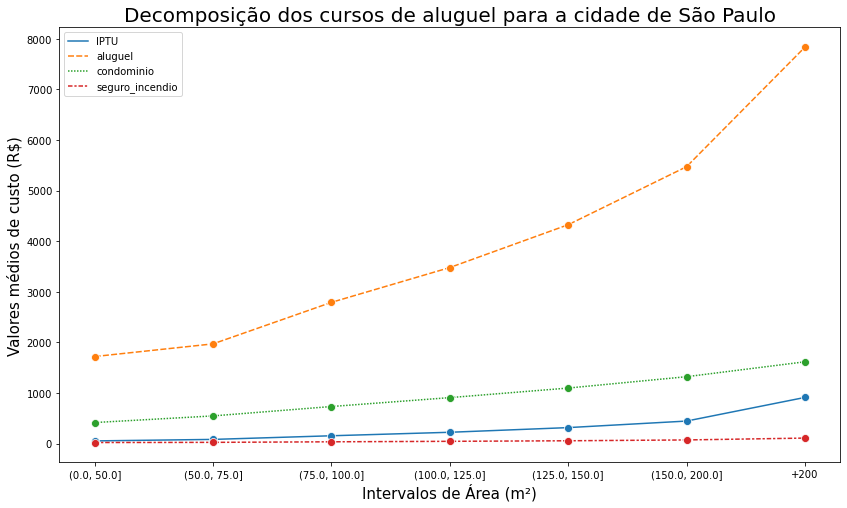

In [46]:
plt.figure(figsize=(14, 8))
x1 = sns.lineplot(data=composicao_area_SP, marker='o', markersize=8)
x1.set_ylabel('Valores médios de custo (R$)', fontdict={'fontsize': 15})
x1.set_xlabel('Intervalos de Área (m²)', fontdict={'fontsize': 15})
x1.set_xticklabels([0] + list(composicao_area_SP['intervalo_area'][:-1]) + ['+200'])
x1.set_title('Decomposição dos cursos de aluguel para a cidade de São Paulo', fontdict={'fontsize': 20})
plt.show()

É possível perceber através do gráfico anterior que o preço médio do aluguel é a feature que sobre maior influência com o aumento da área do imóvel.

<Figure size 1080x720 with 0 Axes>

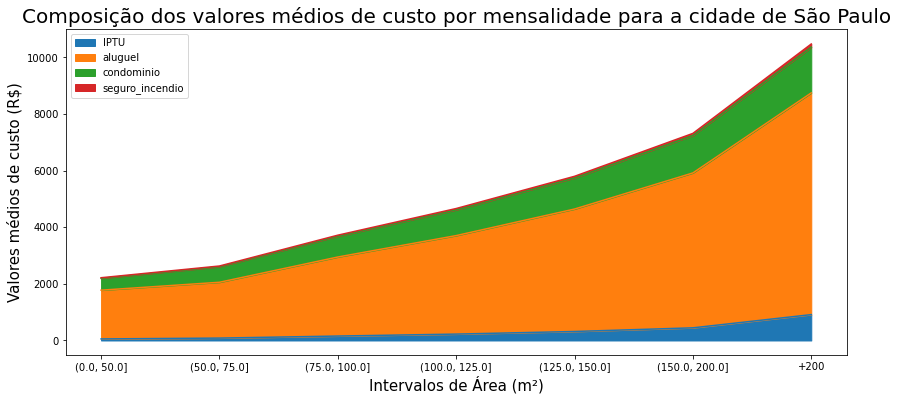

In [60]:
plt.figure(figsize=(15, 10))
x1 = composicao_area_SP.iloc[:,1:].plot.area()
x1.set_ylabel('Valores médios de custo (R$)', fontdict={'fontsize': 15})
x1.set_xlabel('Intervalos de Área (m²)', fontdict={'fontsize': 15})
x1.set_xticklabels([0] + list(composicao_area_SP['intervalo_area'][:-1]) + ['+200'])
x1.set_title('Composição dos valores médios de custo por mensalidade para a cidade de São Paulo', fontdict={'fontsize': 20})
plt.show()

Através do gráfico da composição é possível ver que a o valor do aluguel boa parte do preço médio total do aluguel, seguido pelo valor do condomínio.

In [61]:
composicao_porcentagem = composicao_area_SP[:]
composicao_porcentagem['aluguel_porc'] = composicao_porcentagem['aluguel'] / (composicao_porcentagem['IPTU'] + composicao_porcentagem['aluguel'] + composicao_porcentagem['condominio']+ composicao_porcentagem['seguro_incendio'])
composicao_porcentagem['condominio_porc'] = composicao_porcentagem['condominio'] / (composicao_porcentagem['IPTU'] + composicao_porcentagem['aluguel'] + composicao_porcentagem['condominio']+ composicao_porcentagem['seguro_incendio'])
composicao_porcentagem['IPTU_porc'] = composicao_porcentagem['IPTU'] / (composicao_porcentagem['IPTU'] + composicao_porcentagem['aluguel'] + composicao_porcentagem['condominio']+ composicao_porcentagem['seguro_incendio'])
composicao_porcentagem['seguro_incendio_porc'] = composicao_porcentagem['seguro_incendio'] / (composicao_porcentagem['IPTU'] + composicao_porcentagem['aluguel'] + composicao_porcentagem['condominio']+ composicao_porcentagem['seguro_incendio'])
composicao_porcentagem

,intervalo_area,IPTU,aluguel,condominio,seguro_incendio,aluguel_porc,condominio_porc,IPTU_porc,seguro_incendio_porc
0,"(0.0, 50.0]",54.77,1722.18,417.58,22.77,0.776701,0.188328,0.024701,0.010269
1,"(50.0, 75.0]",84.46,1972.30,548.76,26.15,0.749448,0.208522,0.032094,0.009937
2,"(75.0, 100.0]",156.47,2792.50,734.43,37.26,0.750539,0.197392,0.042054,0.010014
3,"(100.0, 125.0]",225.45,3480.42,910.19,46.69,0.746431,0.195205,0.048351,0.010013
4,"(125.0, 150.0]",317.68,4326.58,1099.20,57.62,0.745823,0.189482,0.054762,0.009933
5,"(150.0, 200.0]",446.90,5472.81,1323.73,73.98,0.747915,0.180901,0.061073,0.010110
6,"(200.0, inf]",913.68,7834.83,1617.82,110.55,0.747821,0.154418,0.087209,0.010552


Investigando mais a fundo a composição do custo total de aluguel, percebemos que o valor médio do aluguel representa por volta de 75% do custo total, enquanto o valor do condomínio cerca de 18%. É possível também enxergar que as proporções se mantêm mesmo com o aumento da área para todas as features analisadas. Então negamos a hipóteses que há variação de composição do custo total de aluguel quando a aumento da área.